# Geothermal Datathon 2021
---

<img src="../figures/the_roaring_kitties_logo.png" width="200" align="center">

Team members:
- **Ricardo Lara**
- **Artur Davletshin**
- **Aigul Akberova**
- **Sercan Gul**
- **Hakki Aydin**
- **Jose Hernandez**


---

### Import Modules

In [3]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import lasio 
import os
import missingno as msno

### Define functions

In [4]:
DV = pd.read_csv('tidy data/Duvernay_Temperatures.csv')
EV = pd.read_csv('tidy data/Eaglebine_Temperatures.csv')

DV_UWIs = list(DV.UWI)
EB_UWIs = list(EV.UWI.astype(str))

## Load LAS files

In [7]:
folder = "../data/Clean_LAS/"
all_files = os.listdir(folder)

las = []
# %%
for i, filename in enumerate(all_files):
    las.append(lasio.read(folder+filename))


In [11]:
las_dfs = {}
UWIs = []
for i, l in enumerate(las):
    UWI = l.well.UWI.value
    
    if UWI not in UWIs:
        UWIs.append(UWI)
        las_dfs[UWI] = l.df()
        las_dfs[UWI]['UWI'] = UWI
    else:
        las_dfs[UWI] = las_dfs[UWI].merge(l.df(), how='left', on='DEPT')


Separate the well logs into daframes for Duvernay and Eaglebine

In [12]:
DV_dfs = [df for i,df in las_dfs.items() if i in DV_UWIs]
EB_dfs = [df for i,df in las_dfs.items() if i in EB_UWIs]

Get all well log names and parameters

In [13]:
DV_curves = {}
EB_curves = {}

for i, l in enumerate(las):
    UWI = l.well.UWI.value
    
    keys = l.sections['Curves'].keys()

    for key in keys:
        curve = l.sections['Curves'][key]
        descr = curve.descr
        unit = curve.unit
       
        if UWI in EB_UWIs and key not in EB_curves.keys():
            EB_curves[key] = [unit, descr]
        elif UWI in DV_UWIs and key not in DV_curves.keys():
            DV_curves[key] = [unit, descr]


Collect all the well logs' names

In [17]:
log_names = {}

In [18]:
log_names['GR'] = [ 
                'GR',              # GAMMA RAY
                'GRWS',            # GAMMA RAY [GRSED]
                'GR_1',            # GAMMA RAY
                'GR_2',            # GAMMA RAY
                'GRN2',            # GAMMA RAY
                'GRN3',            # GAMMA RAY
]

In [19]:
log_names['NPHI_SS'] =[ 
                    'NPHI_SS',     # NEUTRON POROSITY SANDSTONE         
                    'NPHISS',      # NEUTRON POROSITY SANDSTONE     
                    'NPOSSWS',     # NEUTRON POROSITY SANDSTONE [NPORSSED]     
                    'CN_SS',       # COMPENSATED NEUTRON POROSITY SANDSTONE     
                    'CNSSED',      # NEUTRON POROSITY SANDSTONE FROM DENSITY LOG [ADJ. TO RESISTIVITY LOG]     
                    'CNL_SS',      # COMPENSATED NEUTRON POROSITY SANDSTONE     
                    'CNC',         # NEUTRON POROSITY SANDSTONE     
                    ]

In [20]:
log_names['NPHI_LS'] = [
                    'NPOR_LS',      # NEUTRON POROSITY LIMESTONE FROM DENSITY LOG    
                    'NPHILS',       # NEUTRON POROSITY LIMESTONE    
                    'CN_LS',        # COMPENSATED NEUTRON POROSITY LIMESTONE    
                    'NPHI_LS_R',    # NEUTRON POROSITY LIMESTONE REPEAT LOG        
                    'CNSLS',        # COMPENSATED NEUTRON POROSITY LIMESTONE 
                    ]          


In [21]:
log_names['DPHI_SS'] = [
                    'DPHISS',      # DENSITY POROSITY SANDSTONE     
                    'DPOR_SS',     # DENSITY POROSITY SANDSTONE     
                    'DPOSSED',     # LDS DENSITY POROSITY SANDSTONE     
                    'CDLSS',       # COMPENSATED DENSITY POROSITY SANDSTONE     
                    'DPHI_SSED',   # DENSITY POROSITY SANDSTONE  (ADJ TO RES.)
                    ]

In [22]:
log_names['DPHI_LS'] = [
                    'DPOLSWS',    # DENSITY POROSITY LIMESTONE [CONVERTED TO M=2710 F=1000]      
                    'DPHI_LS',    # DENSITY POROSITY LIMESTONE      
                    'DPHILS',     # DENSITY POROSITY LIMESTONE  
                    'CDLLSED',    # COMPENSATED DENSITY POROSITY LIMESTONE [M=2710, F=1000] FROM DENSITY LOG
                    'DPHI_LS_R',  # DENSITY POROSITY LIMESTONE REPEAT LOG      
                    'CDLLS',      # COMPENSATED DENSITY POROSITY LIMESTONE  
                    'DPHI_LSED',  # DENSITY POROSITY LIMESTONE  (ADJ TO RES.)      
                    'DPHZ',       # DENSITY POROSITY LIMESTONE  
                    ]

In [23]:
log_names['PEFZ'] =[
                    'PEFWS',   # PHOTOELECTRIC FACTOR [PEED]         
                    'PEFZ',    # HILT PHOTOELECTRIC FACTOR     
                    'PEFS',    # SHORT SPACED CORRECTED PHOTOELECTRIC FACTOR     
                    ]

In [24]:
log_names['RHOB'] = [
                    'RHOM',         # CORRECTED BULK DENSITY            
                    'RHOB',         # BULK DENSITY                       
                    'RHOBED',       # BULK DENSITY (ADJ TO RES.)       
                    ]

In [ ]:
log_names['SP'] = [
                    'SPWS',      # SPONTANEOUS POTENTIAL BASELINE 0 MV (SPRED)   
                    ]

In [25]:
log_names['CAL'] = [k for k,v in EB_curves.items() if 'CALIPER' in v[1]]

Merge well logs

In [28]:
EB2_dfs = []
for df in EB_dfs:
    df2 = df[['UWI']].copy(deep=True)
    df2[list(log_names.keys())] = np.NAN

    for log, names in log_names.items():
        columns = df.columns.to_list()
        col_names = [x for x in names if x in columns]

        for col in col_names:
            df2[log].mask(df2[log].isnull(), df[col], inplace=True)
    EB2_dfs.append(df2)


In [31]:
for df in EB2_dfs:
    UWI = df.UWI.values[0]
    df.to_csv('tidy data/Eaglebine Well Logs/'+UWI+'.csv')

In [33]:
EB2m = pd.concat(EB2_dfs, axis=0)
EB2m.to_csv('tidy data/EB_well_logs.csv')

<AxesSubplot:>

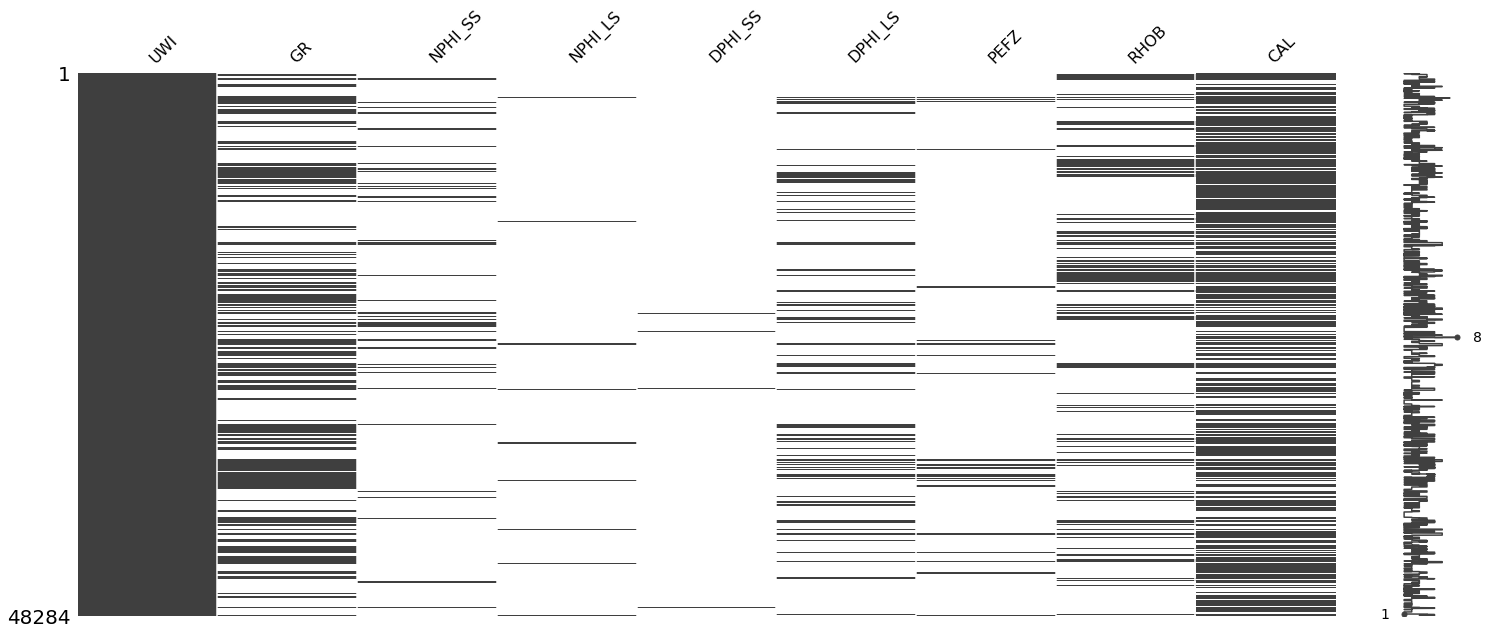

In [34]:
msno.matrix(EB2m)